In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import mnist_reader
from skimage.feature import greycomatrix, greycoprops
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
plt.rcParams["figure.figsize"] = (10,5)

ModuleNotFoundError: No module named 'utils'

In [2]:
test_img = np.array([[0,0,1,1],[0,0,1,1],[0,2,2,2],[2,2,3,3]])

In [3]:
test_img

array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 2, 2, 2],
       [2, 2, 3, 3]])

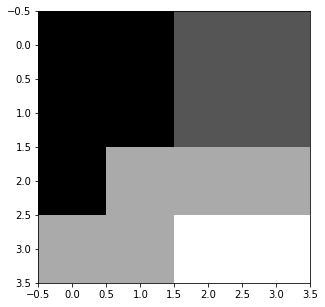

In [4]:
plt.imshow(test_img,cmap='gray')

In [5]:
glcm = greycomatrix(test_img,[1],[np.pi/2],4,symmetric=True,normed=True)

In [6]:
print(glcm.ravel())

[0.25       0.         0.08333333 0.         0.         0.16666667
 0.08333333 0.         0.08333333 0.08333333 0.08333333 0.08333333
 0.         0.         0.08333333 0.        ]


## GLDV

In [7]:
#GLDV (Grey-level difference vector)
def gldv(glcm):
    gldv = np.zeros(len(glcm))
    for i in range(len(glcm)):
        if(i>0):
            gldv[i]=np.trace(glcm, offset=i)*2
        else:
            gldv[i]=np.trace(glcm, offset=i)
            
    return gldv

In [8]:
a = gldv(glcm)

In [9]:
a

array([0.5       , 0.33333333, 0.16666667, 0.        ])

## GLCM  Measures

GLCM proerties from skiimage  
greycoprops(GLCM, prop='measure')  
measure   
‘contrast’: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$  
‘dissimilarity’: $\sum_{i,j=0}^{levels-1} P_{i,j}|i-j|$  
‘homogeneity’ : $\sum_{i,j=0}^{levels-1} \frac{P_{i,j}}{1+(i-j)^2}$  
‘ASM’$\sum_{i,j=0}^{levels-1} P^2_{i,j}$   
‘energy’ $\sqrt{ASM}$  
‘correlation’  $\sum_{i,j=0}^{levels-1} P_{i,j}\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{\sigma_i^2\sigma_j^2}}$

In [5]:
def glcm_props (glcm):
    contrast = greycoprops(glcm,'contrast')
    dissimilarity = greycoprops(glcm,'dissimilarity')
    homogeneity = greycoprops(glcm,'homogeneity')
    ASM = greycoprops(glcm,'ASM')
    #energy = greycoprops(glcm,'energy')
    correlation = greycoprops(glcm,'correlation')
    return np.array([dissimilarity, correlation, contrast, homogeneity, ASM])

## Load Zalando fashion data

In [6]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

Juntamos ambos datasets, ya que vamos a crear nuestro propio dataset más pequeño. La carga de datos que proponen es para realizar un entranamiento de una red neruonal, en nuestro caso vamos a obtener descriptores de las imágenes y utilizar un KNN para realizar la clasificación.

In [7]:
X_dataset = np.concatenate((X_train,X_test))
Y_dataset = np.concatenate((y_train,y_test))

In [8]:
y_labels_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

## Make own dataset (smaller)

De todo el conjunto queremos sacar 100 elementos de 4 clases para obtener los descriptores y clasificar.

In [9]:
def my_sample(X, Y, labels, elements = 100):
    # labels: array con las clases que queremos coger entre 0 y 9 incluidos.
    
    # elements: especificamos cuántos elementos de cada clase queremos coger, máximo de 7000 ya que el conjunto de
    # Zalando tiene 6000+1000 en train+test para cada clase
    
    #Creamos nuestro propio dataset reducido
    my_X_dataset = np.zeros((elements*len(labels),28*28))
    my_Y_dataset = np.zeros(elements*len(labels))
    for i in range(len(labels)):
        ind = (Y==labels[i])
        my_X_dataset[i*elements:elements*(i+1),] = X[ind][0:elements]
        my_Y_dataset[i*elements:elements*(i+1)] = Y[ind][0:elements]

    my_X_dataset = my_X_dataset.astype(np.uint8)
    my_Y_dataset = my_Y_dataset.astype(np.uint8)
    return my_X_dataset, my_Y_dataset

In [33]:
my_X_dataset, my_Y_dataset = my_sample(X_dataset, Y_dataset, elements=200, labels = [0,1,5,8]) #0 1 7 8

In [34]:
# Dividimos nuestro dataset en train y test mediante el uso de train_test_split de scikit-learn
my_X_train, my_X_test, my_y_train, my_y_test = train_test_split(my_X_dataset, my_Y_dataset, test_size=0.2, random_state=42)

In [35]:
# Revisamos la distribución que ha hecho scikit de los datos
u, counts = np.unique(my_y_train, return_counts=True)
print(u)
print(counts)

[0 1 5 8]
[163 157 165 155]


In [23]:
my_X_train.shape

(320, 784)

In [24]:
# Función para calcular las GLCM y sus métricas. Devuelve las GLCM y sus métricas.
# Suponemos que se pasa un dataset de [N,(28*28)] imágenes en escala de grises
def calc_glcm (dataset):
    measures = np.zeros([len(dataset),5])
    # Calulamos todas las medidas para cada imagen.
    glcm_hists = np.zeros([len(dataset),256*256])
    for i in range(len(measures)):
        image = my_X_train[i].reshape(28,28).copy()
        glcm = greycomatrix(image,distances=[1],angles=[0],levels=256,symmetric=True,normed=True)
        glcm_hists[i,:] = glcm.flatten()
        measures[i,:] = glcm_props(glcm).flatten()
    return glcm_hists, measures


In [186]:
# Función para calcular las GLCM y sus métricas. Devuelve las GLCM y sus métricas.
# Suponemos que se pasa un dataset de [N,(28*28)] imágenes en escala de grises
def calc_glcm2 (dataset):
    measures = np.zeros([len(dataset),2])
    # Calulamos todas las medidas para cada imagen.
    glcm_hists = np.zeros([len(dataset),16*16])
    for i in range(len(measures)):
        image = my_X_train[i].reshape(28,28).copy()
        image = np.floor(image/16)
        image = image.astype(np.uint8)
        glcm = greycomatrix(image,distances=[1],angles=[0],levels=16,symmetric=True,normed=True)
        glcm_hists[i,:] = glcm.flatten()
        measures[i,:] = glcm_props(glcm).flatten()
    return glcm_hists, measures


In [36]:
glcm_hist_train , measures_train = calc_glcm(my_X_train)
glcm_hist_test , measures_test = calc_glcm(my_X_test)

In [42]:
def hist_chisquare (H1, H2):
    return np.sum((H1-H2)**2/(H1+1e-16))


In [26]:
my_y_train

array([0, 0, 5, 5, 5, 0, 5, 8, 1, 0, 5, 8, 1, 5, 1, 8, 8, 8, 5, 0, 5, 1,
       0, 0, 1, 0, 0, 1, 8, 8, 1, 8, 5, 8, 5, 0, 0, 5, 8, 5, 1, 1, 0, 8,
       0, 1, 8, 8, 1, 5, 8, 1, 5, 1, 1, 1, 5, 5, 5, 8, 0, 1, 5, 1, 1, 5,
       0, 1, 1, 8, 0, 8, 5, 1, 0, 1, 1, 0, 8, 8, 8, 5, 5, 1, 8, 0, 8, 1,
       1, 5, 0, 0, 1, 0, 1, 8, 0, 5, 0, 0, 0, 1, 1, 1, 0, 1, 8, 5, 8, 1,
       1, 1, 8, 0, 8, 8, 8, 8, 8, 8, 1, 5, 5, 5, 5, 1, 0, 0, 8, 1, 5, 1,
       1, 8, 5, 1, 8, 5, 8, 5, 8, 1, 5, 1, 1, 1, 1, 8, 0, 5, 1, 5, 5, 0,
       1, 8, 5, 8, 8, 8, 8, 1, 0, 8, 0, 0, 8, 1, 5, 5, 1, 5, 1, 5, 0, 8,
       0, 0, 5, 1, 1, 0, 0, 0, 1, 1, 8, 5, 5, 0, 0, 5, 5, 8, 1, 0, 8, 5,
       5, 8, 0, 5, 8, 1, 5, 8, 5, 1, 0, 5, 0, 0, 0, 5, 5, 8, 0, 8, 5, 5,
       5, 1, 8, 1, 0, 1, 1, 0, 0, 8, 0, 1, 0, 8, 8, 5, 5, 8, 5, 5, 5, 5,
       8, 5, 8, 8, 8, 5, 5, 1, 0, 5, 1, 8, 5, 1, 0, 0, 0, 0, 5, 0, 5, 0,
       8, 0, 8, 5, 5, 0, 8, 0, 5, 1, 8, 8, 1, 8, 8, 8, 5, 0, 0, 1, 1, 8,
       1, 1, 0, 0, 8, 5, 5, 0, 8, 1, 5, 1, 5, 8, 5,

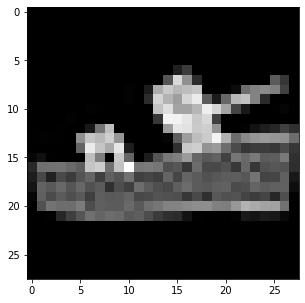

In [27]:
plt.imshow(my_X_train[2].reshape(28,28), cmap='gray')

In [43]:
neigh_glcm = KNeighborsClassifier(n_neighbors=5, metric=hist_chisquare)
neigh_glcm.fit(glcm_hist_train, my_y_train)

y_pred_glcm = neigh_glcm.predict(glcm_hist_test)
print(accuracy_score(my_y_test, y_pred_glcm))
confusion_matrix(my_y_test, y_pred_glcm)

0.2625


array([[ 6, 14,  9,  8],
       [14, 10, 10,  9],
       [ 9,  8, 11,  7],
       [12,  7, 11, 15]], dtype=int64)

In [39]:
neigh_glcm = KNeighborsClassifier(n_neighbors=5, metric = 'euclidean')
neigh_glcm.fit(glcm_hist_train, my_y_train)
y_pred_glcm = neigh_glcm.predict(glcm_hist_test)
print(accuracy_score(my_y_test, y_pred_glcm))
confusion_matrix(my_y_test, y_pred_glcm)

0.2625


array([[ 6, 14,  9,  8],
       [14, 10, 10,  9],
       [ 9,  8, 11,  7],
       [12,  7, 11, 15]], dtype=int64)

In [187]:
glcm_hist_train , measures_train = calc_glcm2(my_X_train)
glcm_hist_test , measures_test = calc_glcm2(my_X_test)

In [192]:
neigh_glcm = KNeighborsClassifier(n_neighbors=5)
neigh_glcm.fit(glcm_hist_train, my_y_train)
y_pred_glcm = neigh_glcm.predict(glcm_hist_test)
print(accuracy_score(my_y_test, y_pred_glcm))
confusion_matrix(my_y_test, y_pred_glcm)

0.225


array([[4, 5, 6, 3],
       [5, 5, 3, 5],
       [7, 3, 3, 5],
       [9, 6, 5, 6]], dtype=int64)

In [41]:
neigh_measures = KNeighborsClassifier(n_neighbors=5, metric = 'euclidean')
neigh_measures.fit(measures_train, my_y_train)

y_pred_measures = neigh_measures.predict(measures_test)

print(accuracy_score(my_y_test, y_pred_measures))
confusion_matrix(my_y_test, y_pred_measures)

0.25


array([[12, 14,  6,  5],
       [19, 11,  9,  4],
       [17,  8,  9,  1],
       [12, 10, 15,  8]], dtype=int64)

In [30]:
# Parámetros para ajustar el descriptor HOG
winSize = (28,28) # Tamaño de nuestra imagen directamente porque queremos un descriptor para toda la imagen
blockSize = (14,14) # 
blockStride = (7,7)
cellSize = (14,14)
nbins = 9
derivAperture = 1 # No cambiar
winSigma = -1. # No cambiar
histogramNormType = 0 # No cambiar
L2HysThreshold = 0.2 # No cambiar
gammaCorrection = 1 # No cambiar
nlevels = 64 # No cambiar
useSignedGradients = True

# Descriptor HOG con los parámetros anteriores
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, useSignedGradients)

# Suponemos que se pasa un dataset de [N,(28*28)] imágenes en escala de grises
def calc_hog (dataset):
    hog_descriptors = np.zeros([len(dataset),81])
    for i in range(len(dataset)):
        hog_descriptors[i,:] = hog.compute(dataset[i].reshape(28,28)).flatten()
    return hog_descriptors   

In [31]:
hog_descriptors_train = calc_hog(my_X_train)
hog_descriptors_test =calc_hog(my_X_test)

In [32]:
neigh_hog = KNeighborsClassifier(n_neighbors=3)
neigh_hog.fit(hog_descriptors_train, my_y_train)
y_pred_hog = neigh_hog.predict(hog_descriptors_test)
print(accuracy_score(my_y_test, y_pred_hog))
confusion_matrix(my_y_test, y_pred_hog)

0.975


array([[25,  1,  0,  0],
       [ 0, 18,  0,  0],
       [ 0,  0, 18,  0],
       [ 0,  0,  1, 17]], dtype=int64)